<a href="https://colab.research.google.com/github/Chandu106/Natural_Language_Processing_SkimLit_Project02/blob/main/SkimLit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9d8d78ee-12a6-13d8-5d4d-270f6bded49d)


# **Get the data from Author's Github**

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.


In [4]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# **PreProcessing the Data**

In [8]:
#creating the function to read the lines in the document
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [9]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 709 ms, sys: 87.4 ms, total: 796 ms
Wall time: 847 ms


(180040, 30212, 30135)

In [12]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

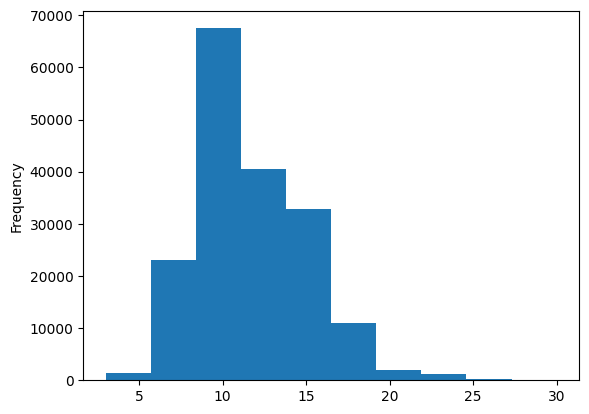

In [15]:
train_df.total_lines.plot.hist();

In [16]:
#convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:14]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# **Make Numerical Labels(ML model require numerical labels)**

In [18]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot[0]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([0., 0., 0., 1., 0.])

In [19]:
#label encode labels
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded[0]

3

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# **Model-0 Baseline Model**

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [22]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
#make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([4, 1, 3, 2, 2])

In [24]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-07-29 17:31:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-29 17:31:33 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# **Preparing our data for deep sequence models**

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

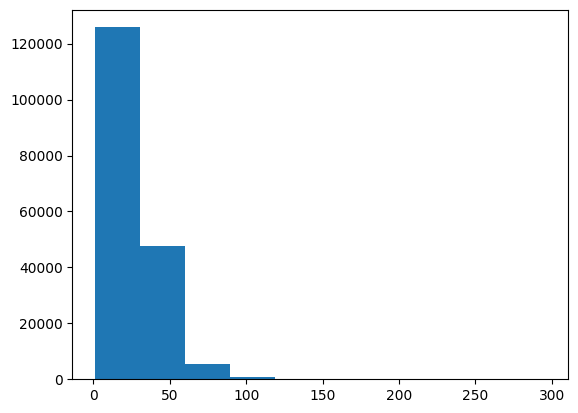

In [29]:
import matplotlib.pyplot as plt
plt.hist(sent_lens)

In [30]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

# **Creating a Text Vectorizer(to convert words into numbers)**

In [31]:
#how many words are there in vocabulary
max_tokens = 68000

In [32]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [33]:
#Adampting text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text: {target_sentence}")
print(f"Length of the text: {len(target_sentence.split())}")
print(f"Vectorized text: {text_vectorizer([target_sentence])}")

Text: similarly , results of the change score correlations were of moderate magnitude ( r @ ) for both measures when compared with changes over time in behavior rating inventory of executive function working memory subscales .
Length of the text: 36
Vectorized text: [[1510  117    4    2  133  101 2378    9    4  362 2081  491   11   54
   213  183   34    7  146  145   63    5  684  699 1370    4 2693  149
  1615  895 2919    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
#how many words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most Common words in the vocabulary: {rct_20k_text_vocab[:20]}")
print(f"Least Common words in the vocabulary: {rct_20k_text_vocab[-20:]}")

Number of words in the vocabulary: 64841
Most Common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment']
Least Common words in the vocabulary: ['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# **Creating custom text embedding(establish relationship between the numbers)**

In [37]:
#creating the embedding layers
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True, #works well for the array containing zeroes
                               name="token_embeddings")


In [38]:
print(f"Sentence before vectorization: {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization: {vectorized_sentence}")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: similarly , results of the change score correlations were of moderate magnitude ( r @ ) for both measures when compared with changes over time in behavior rating inventory of executive function working memory subscales .
Sentence after vectorization: [[1510  117    4    2  133  101 2378    9    4  362 2081  491   11   54
   213  183   34    7  146  145   63    5  684  699 1370    4 2693  149
  1615  895 2919    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Vectorized sentence shape: (1, 55)
Sentence after embedding: [[[ 0.00927011  0.00522503  0.04837606 ... -0.02174687  0.0134068
    0.00745774]
  [ 0.02015388  0.01255727 -0.04182584 ... -0.01260929  0.01160993
   -0.02073371]
  [-0.01514702  0.00289763  0.04431058 ...  0.00722862 -0.00554085
    0.01028223]
  ...
  [ 0.00632402  0.00486963  0.00822042 ... -0.0190855  -0.02026406
   -0.02039029]
  [ 0.00632402  0.00486963  0.00822

# **creating datasets (as fast as possible)**

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# **Model-1 Conv1D with token embeddings**

In [41]:
from keras.api._v2.keras import activations
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embeddings (Embedding  (None, 55, 128)          8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                             

In [43]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs=5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1* len(valid_dataset))) # only validate on 10% of batches

Epoch 1/5
562/562 [==============================] - 45s 61ms/step - loss: 0.8818 - accuracy: 0.6487 - val_loss: 0.6736 - val_accuracy: 0.7424
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6534 - accuracy: 0.7573 - val_loss: 0.6258 - val_accuracy: 0.7736
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6124 - accuracy: 0.7781 - val_loss: 0.5913 - val_accuracy: 0.7872
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5833 - accuracy: 0.7918 - val_loss: 0.5726 - val_accuracy: 0.7909
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5850 - accuracy: 0.7934 - val_loss: 0.5549 - val_accuracy: 0.8015


In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5551 - accuracy: 0.8032


[0.5550944805145264, 0.8032239079475403]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.7573813e-01, 1.5819761e-01, 4.2441662e-02, 1.7241859e-01,
        5.1203948e-02],
       [4.2132416e-01, 3.7069875e-01, 2.5493948e-02, 1.2756523e-01,
        5.4917976e-02],
       [1.7035900e-01, 4.3274802e-03, 1.5170072e-03, 8.2374930e-01,
        4.7204707e-05],
       ...,
       [3.2669406e-05, 6.2373315e-04, 5.8442429e-03, 2.4440642e-05,
        9.9347490e-01],
       [1.0545445e-01, 2.5709730e-01, 1.4827619e-01, 5.8834966e-02,
        4.3033713e-01],
       [1.3310120e-01, 8.1026447e-01, 3.3756591e-02, 8.6664623e-03,
        1.4211289e-02]], dtype=float32)

In [46]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [47]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.32238845491858,
 'precision': 0.8039819956108156,
 'recall': 0.8032238845491858,
 'f1': 0.8001270024614455}

# **Model-2 Feature extraction with pretrained token embeddings**

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [49]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
#u can add more layers aswell
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [51]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9207 - accuracy: 0.6479 - val_loss: 0.7977 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7711 - accuracy: 0.7010 - val_loss: 0.7562 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7546 - accuracy: 0.7122 - val_loss: 0.7392 - val_accuracy: 0.7154


In [52]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7436 - accuracy: 0.7132


[0.7436102628707886, 0.7131603360176086]

In [53]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[0.43733472, 0.37391534, 0.00276222, 0.17872742, 0.00726032],
       [0.34021437, 0.49859124, 0.00492678, 0.15418582, 0.00208165],
       [0.2621214 , 0.14244626, 0.01895816, 0.5395762 , 0.03689802],
       ...,
       [0.00179049, 0.00654152, 0.05608981, 0.00101512, 0.93456304],
       [0.00437095, 0.04505986, 0.1857256 , 0.00145083, 0.7633927 ],
       [0.19853364, 0.24671218, 0.4875686 , 0.00630531, 0.06088026]],
      dtype=float32)

In [54]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.31603336422614,
 'precision': 0.7136461801744547,
 'recall': 0.7131603336422614,
 'f1': 0.7101029200165894}

# **Model-3 Conv1D with Character Embeddings**

In [56]:
random_training_sentence = random.choice(train_sentences)

In [57]:
# making a function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

split_chars(random_training_sentence)

't h e   d i a r r h o e a   d u r a t i o n   i n   t h e   p r o b i o t i c   g r o u p   w a s   t w o   d a y s   w i t h   a n   i n t e r q u a r t i l e   r a n g e   o f   @   -   @   d a y s   a n d   w a s   s i g n i f i c a n t l y   l e s s   (   p   =   @   )   t h a n   t h e   p l a c e b o   g r o u p   w h i c h   w a s   f o u r   d a y s   w i t h   a n   i n t e r q u a r t i l e   r a n g e   o f   @   -   @   d a y s   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [59]:
#average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

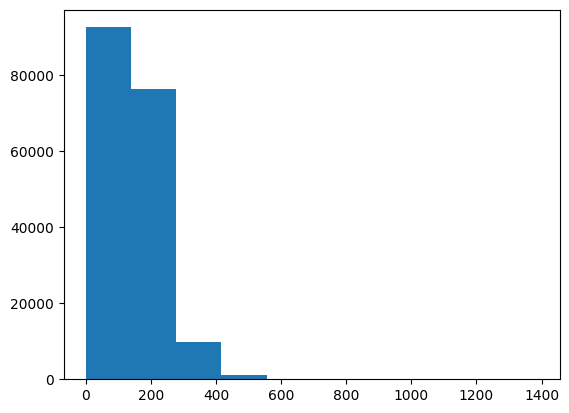

In [60]:
import matplotlib.pyplot as plt
plt.hist(char_lens)

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [64]:
NUM_CHAR_TOKENS

70

In [65]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")


Charified text:
c o m p a r e d   w i t h   h e p a r i n   g p i   ,   a s t   r a t e s   w e r e   h i g h e r   f o r   b i v - l o w   (   @   o f   @   - l s b -   @   %   - r s b -   v s .   @   o f   @   - l s b -   @   %   - r s b -   ;   p   =   @   )   ,   b u t   n o t   d i f f e r e n t   f o r   b i v - p c i   (   @   o f   @   - l s b -   @   %   - r s b -   ;   p   =   @   )   .

Length of chars: 141

Vectorized chars:
[[11  7 15 14  5  8  2 10 20  4  3 13 13  2 14  5  8  4  6 18 14  4  5  9
   3  8  5  3  2  9 20  2  8  2 13  4 18 13  2  8 17  7  8 22  4 21 12  7
  20  7 17 12  9 22  8  9 22 21  9  7 17 12  9 22  8  9 22 14 22 16  3  6
   7  3 10  4 17 17  2  8  2  6  3 17  7  8 22  4 21 14 11  4  7 17 12  9
  22  8  9 22 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0 

In [67]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
c o m p a r e d   w i t h   h e p a r i n   g p i   ,   a s t   r a t e s   w e r e   h i g h e r   f o r   b i v - l o w   (   @   o f   @   - l s b -   @   %   - r s b -   v s .   @   o f   @   - l s b -   @   %   - r s b -   ;   p   =   @   )   ,   b u t   n o t   d i f f e r e n t   f o r   b i v - p c i   (   @   o f   @   - l s b -   @   %   - r s b -   ;   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.04475554  0.04482896  0.03270847 ... -0.03482277  0.02578552
    0.04049264]
  [-0.01963111 -0.02282399  0.04616386 ... -0.00855232 -0.04987733
    0.00807917]
  [ 0.04792719 -0.01675725 -0.03130393 ... -0.03339136 -0.0484218
   -0.02180122]
  ...
  [ 0.01582184  0.03283383  0.0472036  ... -0.00521727 -0.0099928
   -0.03024303]
  [ 0.01582184  0.03283383  0.0472036  ... -0.00521727 -0.0099928
   -0.03024303]
  [ 0.01582184  0.03283383  0.0472036  ... -0.00521727 -0.0099928
   -0.03024303]]]

Charact

In [68]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_character_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [69]:
model_3.summary()

Model: "model_3_conv1d_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 128)          16128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (N

In [70]:
# Create char datasets(for fast computation)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2043 - accuracy: 0.5200 - val_loss: 0.9713 - val_accuracy: 0.6200
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9414 - accuracy: 0.6269 - val_loss: 0.8699 - val_accuracy: 0.6632
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8711 - accuracy: 0.6605 - val_loss: 0.8076 - val_accuracy: 0.6932


In [72]:

# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8300 - accuracy: 0.6804


[0.8300310969352722, 0.6803919076919556]

In [73]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 2s 2ms/step


array([[0.13789093, 0.49004626, 0.07793945, 0.19642715, 0.09769621],
       [0.1976833 , 0.35686192, 0.0038845 , 0.43328968, 0.00828069],
       [0.13044998, 0.11730763, 0.09491037, 0.6293692 , 0.0279628 ],
       [0.01629455, 0.01392492, 0.92240494, 0.01283498, 0.03454066],
       [0.01678886, 0.09470679, 0.5905283 , 0.03475649, 0.26321948]],
      dtype=float32)

In [74]:
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 3, 3, 2, 2])>

In [75]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_3_pred)
model_3_results

{'accuracy': 68.03918972593671,
 'precision': 0.683193056558371,
 'recall': 0.6803918972593671,
 'f1': 0.6701583840699645}

# **Model-4: Combining pretrained token embeddings + character embeddings(Hybrid embedding layer)**

In [91]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [92]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

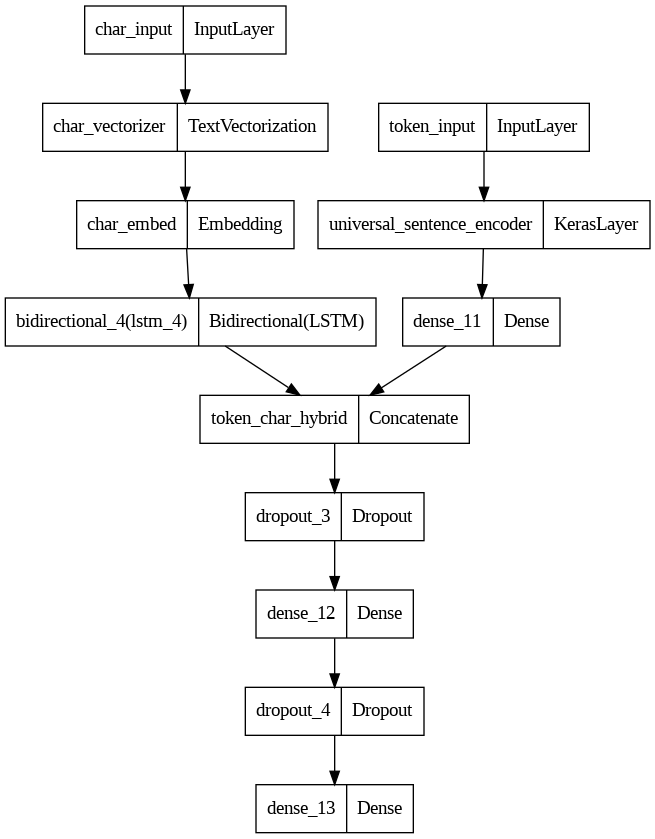

In [93]:
#plotting the models summary
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [100]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [95]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [96]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [99]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 34s 47ms/step - loss: 0.9671 - accuracy: 0.6140 - val_loss: 0.7736 - val_accuracy: 0.6935
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 0.7933 - accuracy: 0.6951 - val_loss: 0.7194 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7726 - accuracy: 0.7076 - val_loss: 0.6886 - val_accuracy: 0.7417


In [101]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 21ms/step - loss: 0.6917 - accuracy: 0.7364


[0.6916574239730835, 0.7363961338996887]

In [102]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[4.7522220e-01, 3.2595289e-01, 5.5063185e-03, 1.8407811e-01,
        9.2405640e-03],
       [3.9138374e-01, 4.0150946e-01, 5.6669987e-03, 1.9911771e-01,
        2.3220149e-03],
       [3.4987983e-01, 1.7074126e-01, 5.7932533e-02, 3.7791097e-01,
        4.3535322e-02],
       ...,
       [5.8341783e-04, 8.8391080e-03, 4.7362085e-02, 2.7061725e-04,
        9.4294477e-01],
       [6.7950240e-03, 7.5515151e-02, 2.6227006e-01, 3.3500085e-03,
        6.5206981e-01],
       [3.3325452e-01, 4.3138587e-01, 1.5018663e-01, 2.7481465e-02,
        5.7691485e-02]], dtype=float32)

In [103]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [104]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.63961339864954,
 'precision': 0.7364005314568769,
 'recall': 0.7363961339864954,
 'f1': 0.7350336541471798}